In [3]:
import pandas as pd
import numpy as np

In [9]:
data = pd.read_csv('./data/sav_2013_2017.csv')
data.head()

,date,av_factor,hits,hour,weekday
0,2013-07-31 00:00:00,0.0,0.0,0.0,2.0
1,2013-07-31 01:00:00,0.0,0.0,1.0,2.0
2,2013-07-31 02:00:00,0.0,0.0,2.0,2.0
3,2013-07-31 03:00:00,0.0,0.0,3.0,2.0
4,2013-07-31 04:00:00,0.0,0.0,4.0,2.0


In [10]:
traffic = data[['av_factor', 'hour', 'weekday', 'hits']][-10000:]

In [11]:
traffic.head()

,av_factor,hour,weekday,hits
28760,4.0,8.0,3.0,55.0
28761,4.0,9.0,3.0,66.0
28762,4.0,10.0,3.0,70.0
28763,4.0,11.0,3.0,49.0
28764,4.0,12.0,3.0,39.0


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
hit_scaler = MinMaxScaler(feature_range=(0,1))

length = len(traffic)

traffic.values[:,0] = scaler.fit_transform(np.matrix(traffic.av_factor).T).reshape((length))
traffic.values[:,1] = scaler.fit_transform(np.matrix(traffic.hour).T).reshape((length))
traffic.values[:,2] = scaler.fit_transform(np.matrix(traffic.weekday).T).reshape((length))

traffic.values[:,3] = hit_scaler.fit_transform(np.matrix(traffic.hits).T).reshape((length))

In [14]:
traffic.hits.mean(), traffic.hits.std()

(0.039824544419134397, 0.069374371729111692)

In [15]:
window_size = 2

In [16]:
def get_rolling_window(data, window_size):
    x, y, val = [], [], len(data) - window_size
    for z in range(val-1):
        x.append(data.values[z:(z + window_size)])
        y.append(data.values[z + window_size,-1:])
    return np.array(x), np.array(y)

In [17]:
split_factor = 0.8
split_row = int(len(traffic) * split_factor)
split_row

8000

In [18]:
train_data, test_data = traffic[:split_row], traffic[split_row:]
X_train, y_train = get_rolling_window(train_data, window_size)
X_test, y_test = get_rolling_window(test_data, window_size)

len(X_train), len(X_test)

(7997, 1997)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

Using TensorFlow backend.


In [22]:
model = Sequential()
batch_size = 1
model.add(SimpleRNN(4, batch_input_shape=(batch_size, window_size, 4), stateful=True, return_sequences=True))
model.add(LSTM(3, batch_input_shape=(batch_size, window_size, 4), stateful=True, return_sequences=True))
model.add(LSTM(5,batch_input_shape=(batch_size, window_size, 4), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=batch_size, shuffle=False)

Train on 7997 samples, validate on 1997 samples
Epoch 1/30
7997/7997 [==============================] - 34s - loss: 0.0017 - val_loss: 0.0195
Epoch 2/30
7997/7997 [==============================] - 33s - loss: 0.0014 - val_loss: 0.0106
Epoch 3/30
7997/7997 [==============================] - 34s - loss: 9.5851e-04 - val_loss: 0.0055
Epoch 4/30
7997/7997 [==============================] - 34s - loss: 7.0833e-04 - val_loss: 0.0048
Epoch 5/30
7997/7997 [==============================] - 34s - loss: 6.0153e-04 - val_loss: 0.0036
Epoch 6/30
7997/7997 [==============================] - 34s - loss: 6.0092e-04 - val_loss: 0.0040
Epoch 7/30
7997/7997 [==============================] - 34s - loss: 5.1845e-04 - val_loss: 0.0037
Epoch 8/30
7997/7997 [==============================] - 34s - loss: 5.2880e-04 - val_loss: 0.0035
Epoch 9/30
7997/7997 [==============================] - 34s - loss: 4.6666e-04 - val_loss: 0.0031
Epoch 10/30
7997/7997 [==============================] - 34s - loss: 4.5346e-0

In [24]:
def inverse_transform(pred):    
    return hit_scaler.inverse_transform(pred)

In [25]:
pred_x_train = model.predict(X_train, batch_size)
pred_train = inverse_transform(pred_x_train)
pred_train[pred_train < 0] = 0.

In [26]:
y_train = np.float_(y_train)
y_train_inv = inverse_transform(y_train)

In [27]:
pred_x_test = model.predict(X_test, batch_size)
pred_test = inverse_transform(pred_x_test)
pred_test[pred_test < 0] = 0.

In [28]:
y_test = np.float_(y_test)
y_test_inv = inverse_transform(y_test)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [30]:
def get_mse(real, pred):
    return math.sqrt(mean_squared_error(real, pred))

def get_mae(real, pred):
    return mean_absolute_error(real, pred)

In [31]:
train_mse = get_mse(y_train_inv, pred_train)
test_mse = get_mse(y_test_inv, pred_test)

print('Train Score: %.2f RMSE' % (train_mse))
print('Test Score: %.2f RMSE' % (test_mse))

Train Score: 92.63 RMSE
Test Score: 88.40 RMSE


In [32]:
train_mae = get_mae(y_train_inv, pred_train)
test_mae = get_mae(y_test_inv, pred_test)

print('Train Score: %.2f MAE' % (train_mae))
print('Test Score: %.2f MAE' % (test_mae))

Train Score: 85.49 MAE
Test Score: 70.91 MAE


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [34]:
line_test_pred = np.reshape(pred_test, pred_test.shape[0])
line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])

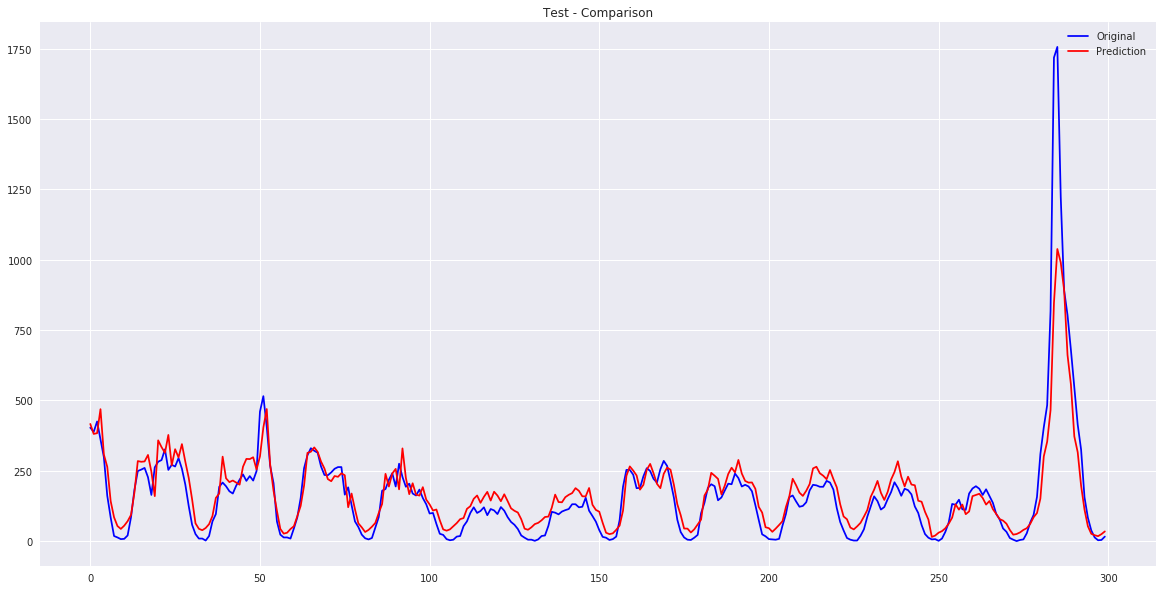

In [35]:
plt.figure(figsize=(20,10))
plt.plot(line_test_real[:300], color='blue',label='Original')
plt.plot(line_test_pred[:300], color='red',label='Prediction')
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

In [36]:
line_train_pred = np.reshape(pred_train, pred_train.shape[0])
line_train_real = np.reshape(y_train_inv, y_train_inv.shape[0])

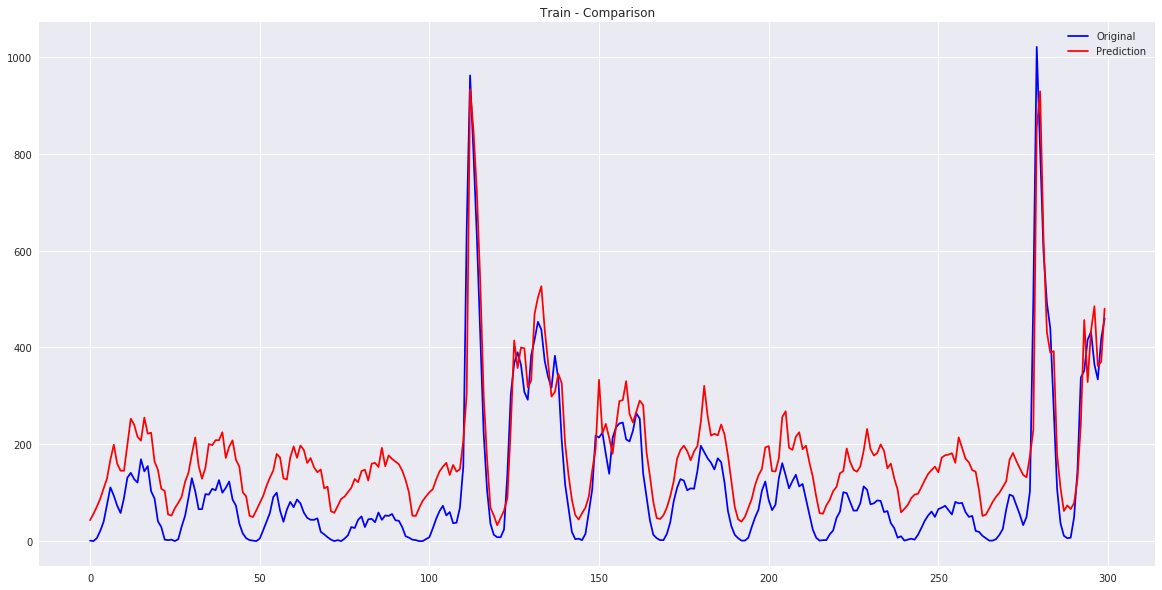

In [37]:
plt.figure(figsize=(20,10))
plt.plot(line_train_real[-300:], color='blue',label='Original')
plt.plot(line_train_pred[-300:], color='red',label='Prediction')
plt.legend(loc='best')
plt.title('Train - Comparison')
plt.show()